##**MSc in Data Science and Economics**
*University of Milan*\
Antonella D'Amico (**961150**)

# **Classification considering Emotion and Sentiment**



1.   Set Environment
2.   Marge data with Sentiment and Emotion information
3.   Oversampling - SMOTE


### 1. Set Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/')
path = '/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/'

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import (train_test_split, 
                                     StratifiedKFold, 
                                     GridSearchCV)

from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score, 
                             ConfusionMatrixDisplay)

# Algorithms
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
import scipy
scaler = StandardScaler(with_mean = False)
Tfidf_vect = TfidfVectorizer()
smote = SMOTE()

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
def makeROC(classifiers, title, rocX_test, rocy_test):
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers:
        model = cls
        yproba = model.predict_proba(rocX_test)[::,1]

        fpr, tpr, _ = roc_curve(rocy_test,  yproba)
        auc = roc_auc_score(rocy_test, yproba)

        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(('ROC Curve Analysis '+title), fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

### 2. Merge data with Sentiment and Emotion information
We prepare the data for the analysis, both train and test set

In [8]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/emotional_df_stack_groupped_pos.pkl", "rb") as f:
    dfemotion = pickle.load(f)

In [10]:
dfemotion = dfemotion.drop(['group_j',	'group_n',	'group_r',	'group_v', 'RB',	'NN',	'VBN', 'JJ', 'VBG', 'VBD', 'NNS', 'VBP'], axis=1)

In [11]:
dfemotion

,index,Title,Link,Label,Description,Original,Text_cleaned,Happy,Angry,Surprise,Sad,Fear,neg,neu,pos
0,0,"""Finally got 5G"": Ryan Reynolds shares photo o...",https://dailyhive.com/vancouver/ryan-reynolds-...,1,Vancouver-raised actor Ryan Reynolds shared a ...,"""Finally got 5G"": Ryan Reynolds shares photo o...",vancouver raised actor ryan reynolds shared se...,0.00,0.00,0.33,0.33,0.33,0.000,0.854,0.146
1,1,Death toll from new coronavirus spikes in just...,https://www.livescience.com/china-coronavirus-...,0,death toll from a new coronavirus in China con...,Death toll from new coronavirus spikes in just...,death toll new coronavirus china continues cli...,0.00,0.00,0.33,0.33,0.33,0.291,0.709,0.000
2,2,The 5G Covid-19 Quackery - Cenerva,https://cenerva.com/the-5g-covid-19-quackery/,0,I say this as I have heard on social media for...,The 5G Covid-19 Quackery - Cenerva I say this ...,say heard social medium forum elsewhere called...,0.00,0.00,0.17,0.17,0.67,0.243,0.757,0.000
3,3,[The epidemiological characteristics of an out...,https://pubmed.ncbi.nlm.nih.gov/32064853/,0,Objective: An outbreak of 2019 novel coronavir...,[The epidemiological characteristics of an out...,objective outbreak novel coronavirus disease c...,0.00,0.00,0.00,0.25,0.75,0.000,0.850,0.150
4,4,"5G, Religion, and Misconceptions in Communicat...",https://journals.usm.ac.id/index.php/the-messe...,0,"di BCE Ndinojuo Pastor Chris Oyakhilome, found...","5G, Religion, and Misconceptions in Communicat...",bce ndinojuo pastor chris oyakhilome founder b...,0.00,0.00,0.25,0.25,0.50,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1157,She says vaccines make you magnetized. This la...,https://ohiocapitaljournal.com/2021/07/14/she-...,0,After a discredited doctor's conspiracy theori...,She says vaccines make you magnetized. This la...,discredited doctor conspiracy theory involving...,0.00,0.00,0.00,0.33,0.67,0.439,0.561,0.000
1158,1158,Fake News: Bill Gates Did NOT Help Fund Patent...,https://leadstories.com/hoax-alert/2020/02/fak...,0,Did billionaire philanthropist and Microsoft c...,Fake News: Bill Gates Did NOT Help Fund Patent...,billionaire philanthropist microsoft founder b...,0.00,0.00,0.50,0.00,0.50,0.000,0.645,0.355
1159,1159,China Wuhan coronavirus: Videos show patients ...,https://www.businessinsider.com/wuhan-coronavi...,1,Wuhan coronavirus patients being transported i...,China Wuhan coronavirus: Videos show patients ...,wuhan coronavirus patient transported box plas...,0.00,0.33,0.00,0.00,0.67,0.180,0.820,0.000
1160,1160,Italy likely to offer third dose of covid vacc...,https://www.wantedinrome.com/news/italy-likely...,0,Covid vaccines to be extended to children in I...,Italy likely to offer third dose of covid vacc...,covid vaccine extended child italy soon regula...,0.00,0.00,0.25,0.00,0.75,0.000,0.915,0.085


In [12]:
X = dfemotion[['Text_cleaned', 'Happy','Angry','Surprise',	'Sad'	,'Fear', 'neg',	'neu', 'pos']]
print(X.shape)
y = dfemotion['Label']
y.shape

(1162, 9)


(1162,)

In [13]:
#Split dataset in training and test set with 80/20 and stratified set to true since it is unbalanced
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 1,
                                                    stratify = y)

In [14]:
fulllist = []
for i in Train_X['Text_cleaned']:
    fulllist.append(i)

In [15]:
Tfidf_vect.fit(fulllist)
Train_X_Tfidf = Tfidf_vect.transform(Train_X['Text_cleaned'])

In [16]:
Train_X = Train_X.reset_index()
index_train = Train_X['index']

In [17]:
#Convert to dataframe
Train_X_df = pd.DataFrame(Train_X_Tfidf.toarray(), columns=Tfidf_vect.get_feature_names())
Train_Y = Train_Y.fillna(0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
Train_X_df = pd.concat([Train_X_df, index_train], axis=1)
Train_X_df = pd.merge(left=Train_X_df, right=Train_X, how='outer', on='index')
Train_X_df = Train_X_df.drop(['index', 'Text_cleaned'], axis = 1)

In [19]:
Train_X_df = scaler.fit_transform(Train_X_df)

#### Test set TF-IDF vectorization + StandardScaler on features

In [23]:
Test_X_Tfidf = Tfidf_vect.transform(Test_X['Text_cleaned'])

In [24]:
Test_X = Test_X.reset_index()
index_test = Test_X['index']

In [25]:
Test_X_df = pd.DataFrame(Test_X_Tfidf.toarray(), columns=Tfidf_vect.get_feature_names())
Test_Y = Test_Y.fillna(0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
Test_X_df = pd.concat([Test_X_df, index_test], axis=1)
Test_X = pd.merge(left=Test_X_df, right=Test_X, how='outer', on='index')
Test_X = Test_X.drop(['Text_cleaned','index'], axis = 1)
Test_X = scaler.transform(Test_X)

## 3. Classification - Oversampling

In [27]:
clf1 = ComplementNB()
clf2 = LogisticRegression(solver='lbfgs')
clf3 = SVC(random_state=1)
clf4 = RandomForestClassifier(random_state=1)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

X_train_smote, y_train_smote = smote.fit_resample(Train_X_df, Train_Y)

### Naive Bayes

In [28]:
param_grid1 = [{'alpha' : [0.5, 1, 10]}]
gcv_model_select = GridSearchCV(estimator=clf1,
                                param_grid=param_grid1,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

NB = gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 97.50%
Best parameters: {'alpha': 0.5}


### Logistic Regression

In [29]:
param_grid2 = [{'penalty': ['l2'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf2,
                                param_grid=param_grid2,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 99.10%
Best parameters: {'C': 1, 'penalty': 'l2'}


### Support Vector Machine

In [30]:
param_grid3 = [{'kernel': ['linear', 'rbf'],
                'C': [1, 0.1, 0.01]}]
gcv_model_select = GridSearchCV(estimator=clf3,
                                param_grid=param_grid3,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV accuracy: 99.51%
Best parameters: {'C': 1, 'kernel': 'linear'}


### Random Forest

In [31]:
param_grid4 = [{'n_estimators': [100, 200, 500]}]
gcv_model_select = GridSearchCV(estimator=clf4,
                                param_grid=param_grid4,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_smote, y_train_smote)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV accuracy: 95.56%
Best parameters: {'n_estimators': 500}


### Save and visualize results

In [32]:
EmoNB = ComplementNB(alpha = 0.5).fit(X_train_smote, y_train_smote)

EmoLR = LogisticRegression(solver='lbfgs', C =  1, penalty = 'l2').fit(X_train_smote, y_train_smote)

EmoSVM = SVC(random_state=1, C = 1, kernel = 'linear', probability=True).fit(X_train_smote, y_train_smote)

EmoRF = RandomForestClassifier(random_state=1, n_estimators = 500).fit(X_train_smote, y_train_smote)

pkl_filename = path + "EmoTFIDFNB_over.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmoNB, file)

pkl_filename = path + "EmoTFIDFLR_over.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmoLR, file)

pkl_filename = path + "EmoTFIDFSVM_over.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmoSVM, file)

pkl_filename = path + "EmoTFIDFRF_over.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(EmoRF, file)

In [33]:
pkl_filename = path + "EmoTFIDFNB_over.pkl"
with open(pkl_filename, 'rb') as file:
    EmoNB = pickle.load(file)
y_pred = EmoNB.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****NB Report****")
print("MultinomialNB Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

pkl_filename = path + "EmoTFIDFLR_over.pkl"
with open(pkl_filename, 'rb') as file:
    EmoLR = pickle.load(file)
y_pred = EmoLR.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****Logistic Regression Report****")
print("LR Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

pkl_filename = path + "EmoTFIDFSVM_over.pkl"
with open(pkl_filename, 'rb') as file:
    EmoSVM = pickle.load(file)
y_pred = EmoSVM.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****SVM Report****")
print("SVM Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

pkl_filename = path + "EmoTFIDFRF_over.pkl"
with open(pkl_filename, 'rb') as file:
    EmoRF = pickle.load(file)
y_pred = EmoRF.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("****Random Forest Report****")
print("Random Forest Accuracy:", metrics.accuracy_score(Test_Y, y_pred))
print('\nClasification report:\n', classification_report(Test_Y, y_pred))
print('\nConfussion matrix:\n', confusion_matrix(Test_Y, y_pred))
print()
print("*"*36)

****NB Report****
MultinomialNB Accuracy: 0.9083094555873925

Clasification report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       309
           1       0.67      0.40      0.50        40

    accuracy                           0.91       349
   macro avg       0.80      0.69      0.72       349
weighted avg       0.90      0.91      0.90       349


Confussion matrix:
 [[301   8]
 [ 24  16]]

************************************
****Logistic Regression Report****
LR Accuracy: 0.9255014326647565

Clasification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       309
           1       0.89      0.40      0.55        40

    accuracy                           0.93       349
   macro avg       0.91      0.70      0.76       349
weighted avg       0.92      0.93      0.91       349


Confussion matrix:
 [[307   2]
 [ 24  16]]

************************************
****SV

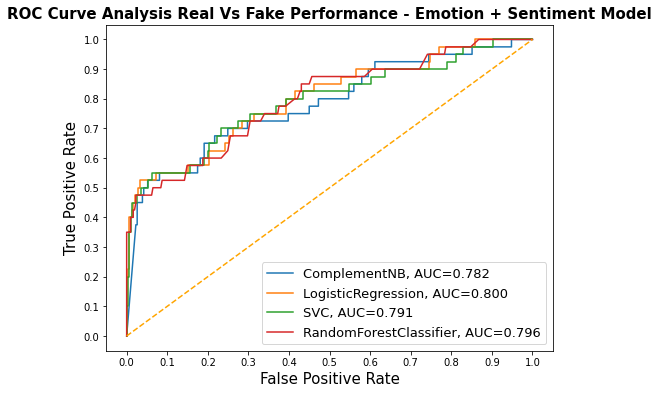

<Figure size 432x288 with 0 Axes>

In [34]:
makeROC([EmoNB, EmoLR, EmoSVM, EmoRF], "Real Vs Fake Performance - Emotion + Sentiment Model", Test_X, Test_Y)
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/ROC_emo_over.png')